# Inteligentne nożyce

## Przygotowanie środowiska

In [80]:
from pathlib import Path
import cv2, timeit, json, numpy as np
from src.pathfinder import Pathfinder
from src.utilities import eval_path
import matplotlib.pyplot as plt
from collections import Counter

In [81]:
data_dir = Path("./data")
configs_dir = data_dir / Path("./configs")
images_dir = data_dir / Path("./images")
paths_txt_dir = data_dir / Path("./paths_txt")
paths_img_dir = data_dir / Path("./paths_img")

times_file = data_dir / Path("./times.txt")
summary_file = data_dir / Path("./summary.txt")

data_dir.mkdir(exist_ok=True)
configs_dir.mkdir(exist_ok=True)
images_dir.mkdir(exist_ok=True)
paths_txt_dir.mkdir(exist_ok=True)
paths_img_dir.mkdir(exist_ok=True)

## Stworzenie zestawu konfiguracji

In [82]:
def create_config_json(json_name, laplace, direction, magnitude):
    jsondict = {
        "laplace_w": laplace,
        "direction_w": direction,
        "magnitude_w": magnitude,
        "laplace_kernels": [3, 5, 7],
        "gaussian_kernel": 5,
        "laplace_weights": [0.2, 0.3, 0.5],
        "maximum_cost": 255,
    }

    with open(json_name, 'w+') as f:
        json.dump(jsondict, f, indent=4)

In [83]:
limit_up = 1
limit_down = 0
step = 0.2

cfg_num = 0
for laplace in np.arange(limit_down, limit_up, step):
    for direction in np.arange(limit_down, limit_up, step):
        for magnitude in np.arange(limit_down, limit_up, step):
            create_config_json(configs_dir / f"cfg_{cfg_num:05}.json", laplace, direction, magnitude)
            cfg_num += 1
print(f"Created {cfg_num} configurations!")

Created 125 configurations!


## Funkcje

In [84]:
def run_algo(image, path_reference, selected_points, iterations, img_name):
    scores = {}
    times = {}
    parameters = {}
    min_configs = []
    min_score = np.inf

    output_images_dir = images_dir / img_name
    output_images_dir.mkdir(exist_ok=True)
    output_paths_img_dir = paths_img_dir / img_name
    output_paths_img_dir.mkdir(exist_ok=True)

    min_images = {}
    min_path_images = {}
    for cfg in configs_dir.glob("*.json"):
        all_paths = []
        cfg_num = cfg.stem.split("_")[1]

        with open(cfg, 'r') as f:
            config_params = json.load(f)
        parameters[cfg] = {
            "l": config_params["laplace_w"],
            "d": config_params["direction_w"],
            "m": config_params["magnitude_w"]
        }
        for it in range(iterations):
            if not cfg in times:
                times[cfg] = {}
            if not "total" in times[cfg]:
                times[cfg]["total"] = []
            if not cfg in scores:
                scores[cfg] = []

            # print(f"\r Processing configuration: {cfg}, iteration: {it}", end="")
            image_temp = image.copy()
            path_image = np.zeros_like(image)

            pathfinder = Pathfinder(image, config_file=cfg)

            path = []
            time_total = 0
            for i in range(len(selected_points)-1):
                
                if not i in times[cfg]:
                    times[cfg][i] = []
                start_xy = selected_points[i]
                end_xy = selected_points[i+1]
                print(f"\r Processing configuration: {cfg}, iteration: {it}, from {start_xy} to {end_xy} ({i}-th pair)", end="")
                t_start = timeit.default_timer()
                found_path = pathfinder.find_path(start_xy, end_xy)
                t_end = timeit.default_timer()
                exec_time = t_end - t_start
                time_total += exec_time
                times[cfg][i].append(exec_time)
                path.extend(found_path)
            times[cfg]["total"].append(time_total)

            for x, y in path:
                image_temp[x, y, :] = (255, 255, 0)
                path_image[x, y, :] = (255, 255, 255)

            path_score, hits, misses = eval_path(path_image, path_reference)
            scores[cfg].append(path_score)

            if path_score == min_score:
                min_configs.add(cfg)
                min_images[cfg] = image_temp.copy()
                min_path_images[cfg] = path_image.copy()
            elif path_score < min_score:
                min_score = path_score
                min_configs = set([cfg])
                min_images = {cfg: image_temp.copy()}
                min_path_images = {cfg: path_image.copy()}

        if not all(all_paths[0] == l for l in all_paths[1:]):
            print(f"\rThere are inconsistencies in path found for {cfg} file")
    for mcfg in min_images:
        mcfg_num = mcfg.stem.split("_")[1]
        cv2.imwrite(str(output_images_dir / f"img_{mcfg_num}.png"), min_images[mcfg])
        cv2.imwrite(str(output_paths_img_dir / f"path_{mcfg_num}.png"), min_path_images[mcfg])
        
    print("\nDone!")
    return image_temp, path_image, parameters, min_score, min_configs, scores, times
            

In [85]:
def params_plot(avg_scores, avg_times, parameters, min_configs):
    avg_scores_vs_l = [[], []]
    avg_scores_vs_d = [[], []]
    avg_scores_vs_m = [[], []]
    avg_times_vs_l = [[], []]
    avg_times_vs_d = [[], []]
    avg_times_vs_m = [[], []]

    for k in parameters:
        l = parameters[k]["l"]
        d = parameters[k]["d"]
        m = parameters[k]["m"]
        avg_scores_vs_l[0].append(avg_scores[k])
        avg_scores_vs_l[1].append(l)
        avg_scores_vs_d[0].append(avg_scores[k])
        avg_scores_vs_d[1].append(d)
        avg_scores_vs_m[0].append(avg_scores[k])
        avg_scores_vs_m[1].append(m)
        avg_times_vs_l[0].append(avg_times[k])
        avg_times_vs_l[1].append(l)
        avg_times_vs_d[0].append(avg_times[k])
        avg_times_vs_d[1].append(d)
        avg_times_vs_m[0].append(avg_times[k])
        avg_times_vs_m[1].append(m)
    fig, axs = plt.subplots(3, 2, figsize=(15,15))

    axs[0, 0].plot(*avg_scores_vs_l, '.', color='b')
    axs[0, 0].set_xlabel("Score [miss/total pixel count]")
    axs[0, 0].set_ylabel("Laplace transform multiplier")
    axs[0, 0].grid(True, "both")
    axs[0, 0].set_title("Score vs Laplace transform multiplier")

    axs[1, 0].plot(*avg_scores_vs_d, '.', color='b')
    axs[1, 0].set_xlabel("Score [miss/total pixel count]")
    axs[1, 0].set_ylabel("Direction multiplier")
    axs[1, 0].grid(True, "both")
    axs[0, 0].set_title("Score vs direction multiplier")

    axs[2, 0].plot(*avg_scores_vs_m, '.', color='b')
    axs[2, 0].set_xlabel("Score [miss/total pixel count]")
    axs[2, 0].set_ylabel("Magnitude multiplier")
    axs[2, 0].grid(True, "both")
    axs[0, 0].set_title("Score vs magnitude multiplier")

    axs[0, 1].plot(*avg_times_vs_l, '.', color='b')
    axs[0, 1].set_xlabel("Total execution time [s]")
    axs[0, 1].set_ylabel("Laplace transform multiplier")
    axs[0, 1].grid(True, "both")
    axs[0, 0].set_title("Score vs Laplace transform multiplier")

    axs[1, 1].plot(*avg_times_vs_d, '.', color='b')
    axs[1, 1].set_xlabel("Total execution time [s]")
    axs[1, 1].set_ylabel("Direction multiplier")
    axs[1, 1].grid(True, "both")
    axs[0, 0].set_title("Score vs direction multiplier")

    axs[2, 1].plot(*avg_times_vs_m, '.', color='b')
    axs[2, 1].set_xlabel("Total execution time [s]")
    axs[2, 1].set_ylabel("Magnitude multiplier")
    axs[2, 1].grid(True, "both")
    axs[0, 0].set_title("Score vs magnitude multiplier")

    for mcfg in list(min_configs):
        l = parameters[mcfg]["l"]
        d = parameters[mcfg]["d"]
        m = parameters[mcfg]["m"]
        min_score = avg_scores[mcfg]
        min_time = avg_times[mcfg]
        axs[0, 0].plot(min_score, l, '.', color='r')
        axs[1, 0].plot(min_score, d, '.', color='r')
        axs[2, 0].plot(min_score, m, '.', color='r')
        axs[0, 1].plot(min_time, l, '.', color='r')
        axs[1, 1].plot(min_time, d, '.', color='r')
        axs[2, 1].plot(min_time, m, '.', color='r')
    
    plt.show()

## Analiza obrazów

In [86]:
iterations = 100

### DEV TEST

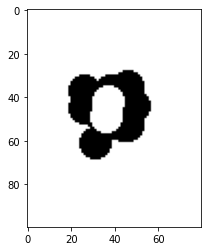

In [87]:
image = cv2.imread("./testimage3.png")
path_reference = cv2.imread("testimage3_path_reference.png")
selected_points = [(19, 41), (34, 29), (54, 50), (24,64), (19, 41)]
plt.imshow(image)

In [88]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "dev")

 Processing configuration: data\configs\cfg_00000.json, iteration: 27, from (19, 41) to (34, 29) (0-th pair)

KeyboardInterrupt: 

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

Min score: 0.019375
Min configs:
data\configs\cfg_00011.json
data\configs\cfg_00014.json
data\configs\cfg_00006.json
data\configs\cfg_00009.json
data\configs\cfg_00010.json
data\configs\cfg_00005.json
data\configs\cfg_00015.json
data\configs\cfg_00007.json


In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

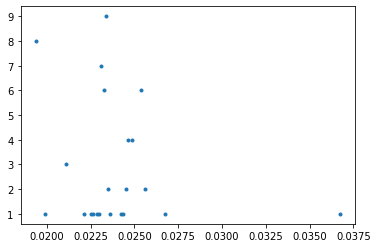

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

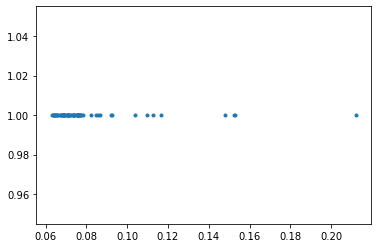

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

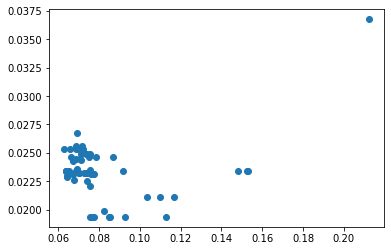

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

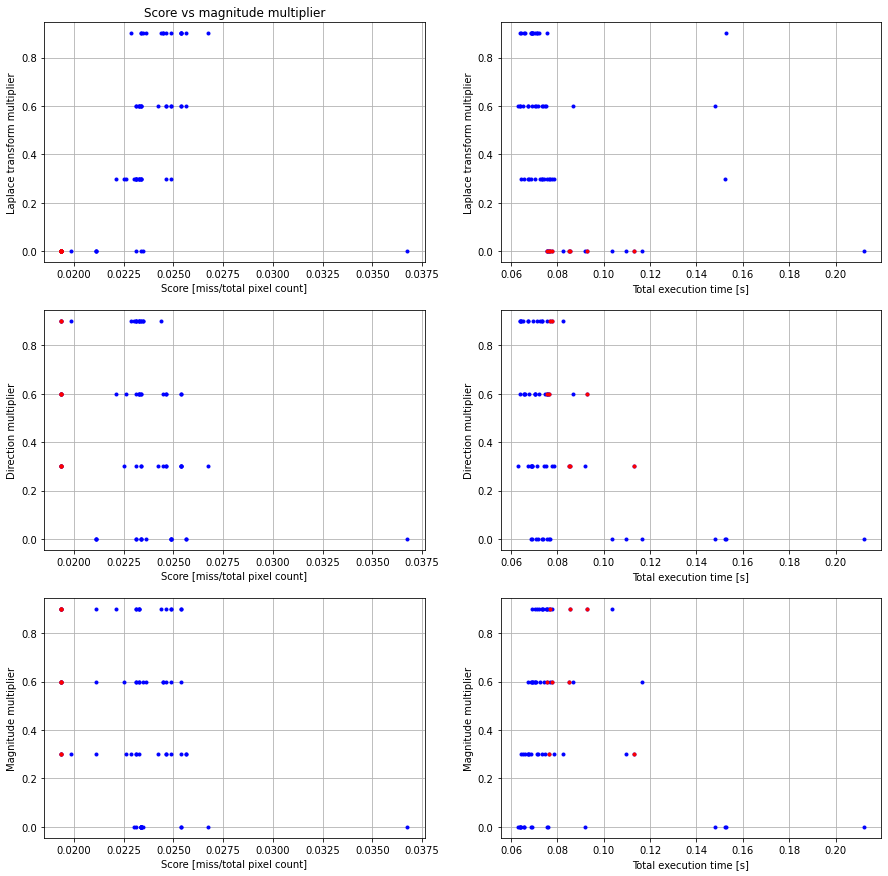

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 0

In [ ]:
image = cv2.imread("./test_images/obraztestowy_0.png")
path_reference = cv2.imread("./test_images/obraztestowy_0_path.png")
selected_points = [(50,85), (86,83), (80,58), (68,22), (42,18), (10,35), (20,63), (30,94), (50,85)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test00")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 1

In [ ]:
image = cv2.imread("./test_images/obraztestowy_1.png")
path_reference = cv2.imread("./test_images/obraztestowy_1_path.png")
selected_points = [(65,59), (79,49), (72,24), (46,33), (49,53), (65,59)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test01")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 2

In [ ]:
image = cv2.imread("./test_images/obraztestowy_2.png")
path_reference = cv2.imread("./test_images/obraztestowy_2_path.png")
selected_points = [(50,85), (86,83), (80,58), (68,22), (42,18), (10,35), (20,63), (30,94), (50,85)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test02")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 3

In [ ]:
image = cv2.imread("./test_images/obraztestowy_3.png")
path_reference = cv2.imread("./test_images/obraztestowy_3_path.png")
selected_points = [(67, 71), (84,54), (80,40), (64,33), (46,52), (67,71)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test03")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 4

In [ ]:
image = cv2.imread("./test_images/obraztestowy_4.png")
path_reference = cv2.imread("./test_images/obraztestowy_4_path.png")
selected_points = [(67, 71), (84,54), (80,40), (64,33), (46,52), (67,71)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test04")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 5

In [ ]:
image = cv2.imread("./test_images/obraztestowy_5.png")
path_reference = cv2.imread("./test_images/obraztestowy_5_9_path.png")
selected_points = [(382,510), (381,496), (379,489), (373, 469), (373, 466), (368,454), (371, 425), (376, 356), (368, 292), (367, 221), (370, 209), (385, 198), (397, 186), (409, 166), (412, 156), (413, 116), (412, 110), (370, 130), (345, 144), (329, 121), (325, 110), (313, 97), (305, 91), (295, 75), (274, 62), (218, 45), (150, 78), (123, 129), (118, 181), (126, 201), (139, 239), (90, 289), (83, 348), (74, 391), (65, 510)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test05")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 6

In [ ]:
image = cv2.imread("./test_images/obraztestowy_6.png")
path_reference = cv2.imread("./test_images/obraztestowy_5_9_path.png")
selected_points = [(382,510), (381,496), (379,489), (373, 469), (373, 466), (368,454), (371, 425), (376, 356), (368, 292), (367, 221), (370, 209), (385, 198), (397, 186), (409, 166), (412, 156), (413, 116), (412, 110), (370, 130), (345, 144), (329, 121), (325, 110), (313, 97), (305, 91), (295, 75), (274, 62), (218, 45), (150, 78), (123, 129), (118, 181), (126, 201), (139, 239), (90, 289), (83, 348), (74, 391), (65, 510)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test06")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 7

In [ ]:
image = cv2.imread("./test_images/obraztestowy_7.png")
path_reference = cv2.imread("./test_images/obraztestowy_5_9_path.png")
selected_points = [(382,510), (381,496), (379,489), (373, 469), (373, 466), (368,454), (371, 425), (376, 356), (368, 292), (367, 221), (370, 209), (385, 198), (397, 186), (409, 166), (412, 156), (413, 116), (412, 110), (370, 130), (345, 144), (329, 121), (325, 110), (313, 97), (305, 91), (295, 75), (274, 62), (218, 45), (150, 78), (123, 129), (118, 181), (126, 201), (139, 239), (90, 289), (83, 348), (74, 391), (65, 510)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test07")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 8

In [ ]:
image = cv2.imread("./test_images/obraztestowy_8.png")
path_reference = cv2.imread("./test_images/obraztestowy_5_9_path.png")
selected_points = [(382,510), (381,496), (379,489), (373, 469), (373, 466), (368,454), (371, 425), (376, 356), (368, 292), (367, 221), (370, 209), (385, 198), (397, 186), (409, 166), (412, 156), (413, 116), (412, 110), (370, 130), (345, 144), (329, 121), (325, 110), (313, 97), (305, 91), (295, 75), (274, 62), (218, 45), (150, 78), (123, 129), (118, 181), (126, 201), (139, 239), (90, 289), (83, 348), (74, 391), (65, 510)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test08")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 9

In [ ]:
image = cv2.imread("./test_images/obraztestowy_9.png")
path_reference = cv2.imread("./test_images/obraztestowy_5_9_path.png")
selected_points = [(382,510), (381,496), (379,489), (373, 469), (373, 466), (368,454), (371, 425), (376, 356), (368, 292), (367, 221), (370, 209), (385, 198), (397, 186), (409, 166), (412, 156), (413, 116), (412, 110), (370, 130), (345, 144), (329, 121), (325, 110), (313, 97), (305, 91), (295, 75), (274, 62), (218, 45), (150, 78), (123, 129), (118, 181), (126, 201), (139, 239), (90, 289), (83, 348), (74, 391), (65, 510)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test09")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 10

In [ ]:
image = cv2.imread("./test_images/obraztestowy_10.png")
path_reference = cv2.imread("./test_images/obraztestowy_10_13_path.png")
selected_points = [(381, 509), (370, 462), (386, 381), (382, 318), (372, 247), (367, 211), (416, 112), (396, 110), (383, 120), (344, 144), (217, 45), (126, 115), (121, 136), (119, 185), (126, 204), (139, 238), (108, 262), (89, 279), (79, 382), (67, 509)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test10")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 11 (64)

In [ ]:
image = cv2.imread("./test_images/obraztestowy_64.png")
path_reference = cv2.imread("./test_images/obraztestowy_64_path.png")
selected_points = [(48, 63), (47, 54), (47, 36), (46, 27), (51, 23), (51, 15), (51, 13), (47, 15), (44, 17), (43, 15), (39, 11), (35, 6), (28,5), (21, 7), (16, 14), (15, 19), (15, 24), (17, 30), (11, 35), (9, 43), (7, 52), (8, 63)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test11")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 12 (128)

In [ ]:
image = cv2.imread("./test_images/obraztestowy_128.png")
path_reference = cv2.imread("./test_images/obraztestowy_128_path.png")
selected_points = [(96, 126), (92, 112), (97,98), (93,52), (104, 28), (98, 27), (93, 32), (86, 35), (75, 19), (41, 16), (30, 46), (31, 62), (21, 72), (16, 126)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test12")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)

### Obraz testowy 13 (1024)

In [ ]:
image = cv2.imread("./test_images/obraztestowy_1024.png")
path_reference = cv2.imread("./test_images/obraztestowy_1024_path.png")
selected_points = [(766, 1021), (742, 927), (758, 845), (768, 743), (763,662), (744, 493), (729, 420), (829, 231), (787, 222), (757, 246), (702, 279), (691, 291), (424, 91), (257, 223), (276, 480), (231, 513), (182, 560), (143, 822), (126, 1022)]
plt.imshow(image)

In [ ]:
image_with_path, path_image, parameters, min_score, min_configs, scores, times = run_algo(image, path_reference, selected_points, iterations, "test13")

In [ ]:
print("Min score:", min_score)
print("Min configs:")
for cfg in list(min_configs):
    print(cfg)

In [ ]:
avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
avg_times =  {k: sum(v["total"])/len(v["total"]) for k, v in times.items()}

In [ ]:
scores_vals = [sum(s)/len(s) for s in scores.values()]
counted_scores = dict(Counter(scores_vals))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()

In [ ]:
times_vals = [sum(s["total"])/len(s["total"]) for s in times.values()]
counted_scores = dict(Counter(times_vals))
ctimes_vals, ctimes_count = zip(*counted_scores.items())
plt.plot(ctimes_vals, ctimes_count, '.')
plt.show()

In [ ]:
plt.plot(times_vals, scores_vals, 'o')
plt.show()

In [ ]:
params_plot(avg_scores, avg_times, parameters, min_configs)